In [1]:
from pint import UnitRegistry; AssignQuantity = UnitRegistry().Quantity
import numpy as np
from copy import copy as cp
import matplotlib.pylab as plt
from scipy.integrate import solve_ivp
from numba import njit, float64, int32, types
from matplotlib import rcParams
from time import time

Iwantrfft = True; Iwantfft = not Iwantrfft
if Iwantrfft:
    from scipy.fft import rfft, irfft, rfftfreq
    my_fft = rfft
    my_ifft = irfft
    my_fftfreq = rfftfreq
else:
    from scipy.fft import fft, ifft, fftfreq
    my_fft = fft
    my_ifft = ifft
    my_fftfreq = fftfreq

import sys
sys.path.append('..')
import QLCstuff as QLC
import f90nml

In [2]:
%matplotlib ipympl
%matplotlib notebook
ticklabelsize = 30
linewidth = 1
fontsize = 30
titlefontsize = 8
markersize = 10

figsize = (10,8)
fontsize = 35
margin = 0.2

In [3]:
inputfile = "GI parameters - Reference limit cycle (for testing).nml"

# For readability ...
print('Using parameter file '+inputfile+' ...')

print('\nFrom the GrowthInstability (GI) namelist:')
GI=f90nml.read(inputfile)['GI'] # Read the main parameter namelist

# Supersaturation at the corner of a facet
sigmaI_corner = GI['sigmaI_corner']
sigmaI_corner_units = GI['sigmaI_corner_units']
sigmaI_corner = AssignQuantity(sigmaI_corner,sigmaI_corner_units)
print('sigmaI_corner =', sigmaI_corner)

# Difference in equilibrium supersaturation between microsurfaces I and II
sigma0 = GI['sigma0']
sigma0_units = GI['sigma0_units']
sigma0 = AssignQuantity(sigma0,sigma0_units)
print('sigma0 =',sigma0)

# Reduction of supersaturation at the facet cental
c_r = GI['c_r']
c_r_units = GI['c_r_units']
c_r = AssignQuantity(c_r,c_r_units)
print('c_r =',c_r)

# Properties of the QLL
Nbar = GI['Nbar']; print('Nbar', Nbar)
Nstar = GI['Nstar']; print('Nstar', Nstar)

# Thickness of monolayers
h_pr = GI['h_pr']
h_pr_units = GI['h_pr_units']
h_pr = AssignQuantity(h_pr,h_pr_units) 
print('h_pr =', h_pr)

# Diffusion coeficient
D = GI['D']
D_units = GI['D_units']
D = AssignQuantity(D,D_units)
print('D =', D)

# Deposition velocity
nu_kin = GI['nu_kin']
nu_kin_units = GI['nu_kin_units']
nu_kin = AssignQuantity(nu_kin,nu_kin_units)
print('nu_kin =', nu_kin)

# Size of the facet
L = GI['L']
L_units = GI['L_units']
L = AssignQuantity(L,L_units)
print('L =', L)

# Crystal size -- needs to be an even number
nx_crystal = GI['nx_crystal']
print('nx (crystal) =', nx_crystal)

# Time constant for freezing/thawing
tau_eq = GI['tau_eq']
tau_eq_units = GI['tau_eq_units']
tau_eq = AssignQuantity(tau_eq,tau_eq_units)
print('tau_eq =',tau_eq)

# Integration algorithm (possibilities: RK45, BDF, RK23, DOP853, LSODA, and Radau)
odemethod = GI['odemethod']
print('odemethod =',odemethod)

Using parameter file GI parameters - Reference limit cycle (for testing).nml ...

From the GrowthInstability (GI) namelist:
sigmaI_corner = 0.23 dimensionless
sigma0 = 0.2 dimensionless
c_r = 0.005 dimensionless
Nbar 1
Nstar 0.1
h_pr = 0.389 nanometer
D = 0.000365 micrometer ** 2 / microsecond
nu_kin = 70 micrometer / second
L = 30 micrometer
nx (crystal) = 320
tau_eq = 5 microsecond
odemethod = RK45


In [4]:
# Conversions (in case inputs are in other units)
sigma0.ito('dimensionless')
h_pr.ito('micrometer')
D.ito('micrometer^2/microsecond')
nu_kin.ito('micrometer/second')
L.ito('micrometer')
sigmaI_corner.ito('dimensionless')
c_r.ito('dimensionless')
tau_eq.ito('microsecond')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Spacing of points on the ice surface = 0.18808777429467227 micrometer


0.22999999999999998 <Unit('dimensionless')>

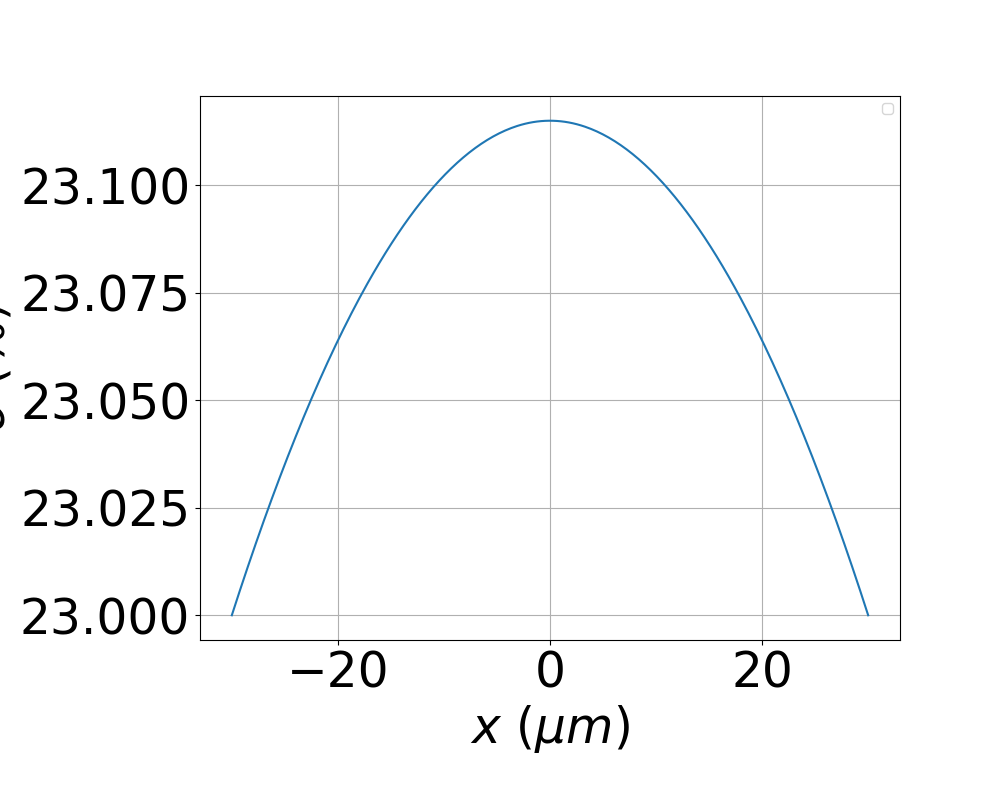

In [30]:
x_QLC = np.linspace(-L,L,nx_crystal)
deltax = x_QLC[1]-x_QLC[0]
print('Spacing of points on the ice surface =', deltax)

sigmaI_QLC = sigmaI_corner*(c_r*(x_QLC/L)**2+1-c_r) #keep 0 c_r = 0.5%, sigmaI_corner = 0.21, L = 30
sigmaI_QLC = -1 * sigmaI_QLC + 2 * sigmaI_QLC[0] #keep1
#sigmaI_QLC = np.cos(1/(np.pi *2) * x_QLC.magnitude) * c_r / 10 - c_r / 10 + sigmaI_corner #keep2
#sigmaI_QLC = sigmaI_corner + (x_QLC.magnitude)**4 * c_r / 4000000
nu_kin_mlyperus = nu_kin/h_pr
nu_kin_mlyperus.ito('1/microsecond')
Doverdeltax2 = D/deltax**2
len(sigmaI_QLC)

#keep3
""" for i in range(len(sigmaI_QLC)):
    if(i < 20 or i >= 300):
        sigmaI_QLC[i] = 0.211
    elif(i < 40 or i >= 280):
        sigmaI_QLC[i] = 0.211
    elif(i < 60 or i >= 260):
        sigmaI_QLC[i] = 0.211
    elif(i < 80 or i >= 240):
        sigmaI_QLC[i] = 0.211
    elif(i < 100 or i >= 220):
        sigmaI_QLC[i] = 0.210
    elif(i < 120 or i >= 200):
        sigmaI_QLC[i] = 0.210
    elif(i < 140 or i >= 180):
        sigmaI_QLC[i] = 0.210
    else:
        sigmaI_QLC[i] = 0.21
 """
    

plt.figure(figsize=(figsize))
plt.plot(x_QLC,sigmaI_QLC * 100)
plt.xlabel('$x \ (\mu m$)',fontsize=fontsize)
plt.ylabel('$\sigma$ (%)',fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.subplots_adjust(bottom=margin) 
plt.subplots_adjust(left=margin)
plt.grid(True)
plt.legend()

sigmaI_QLC[-1]

In [6]:
RT=f90nml.read(inputfile)['RT'] # Read the main parameter namelist

# How long
runtime = RT['runtime']
runtime_units = RT['runtime_units']
runtime = AssignQuantity(runtime,runtime_units)
print('runtime =', runtime)
runtime.ito('microsecond')

# Number of time steps to keep for reporting later
ntimes = RT['ntimes']

# Flag if we want more output
verbose = RT['verbose']

# Specify the time interval and initial conditions
tkeep_1Darr = np.linspace(0,runtime,ntimes)
Ntot_init_1D = np.ones(nx_crystal)
NQLL_init_1D = QLC.getNQLL(Ntot_init_1D,Nstar,Nbar)

print('This is a run from time', tkeep_1Darr[0].to('msec'),'to', tkeep_1Darr[-1].to('msec'))
print('dt =', tkeep_1Darr[1]-tkeep_1Darr[0])

runtime = 400 millisecond
This is a run from time 0.0 millisecond to 400.0 millisecond
dt = 2010.0502512562814 microsecond


10 % elapsed time is 0.172 minutes
20 % elapsed time is 0.331 minutes
30 % elapsed time is 0.493 minutes
40 % elapsed time is 0.658 minutes
50 % elapsed time is 0.822 minutes
60 % elapsed time is 0.986 minutes
70 % elapsed time is 1.150 minutes
80 % elapsed time is 1.314 minutes
90 % elapsed time is 1.478 minutes


C:\Users\spenc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\cbook\__init__.py:1335: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


100% done
status =  0
message =  The solver successfully reached the end of the integration interval.
['message', 'nfev', 'njev', 'nlu', 'sol', 'status', 'success', 't', 't_events', 'y', 'y_events']


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


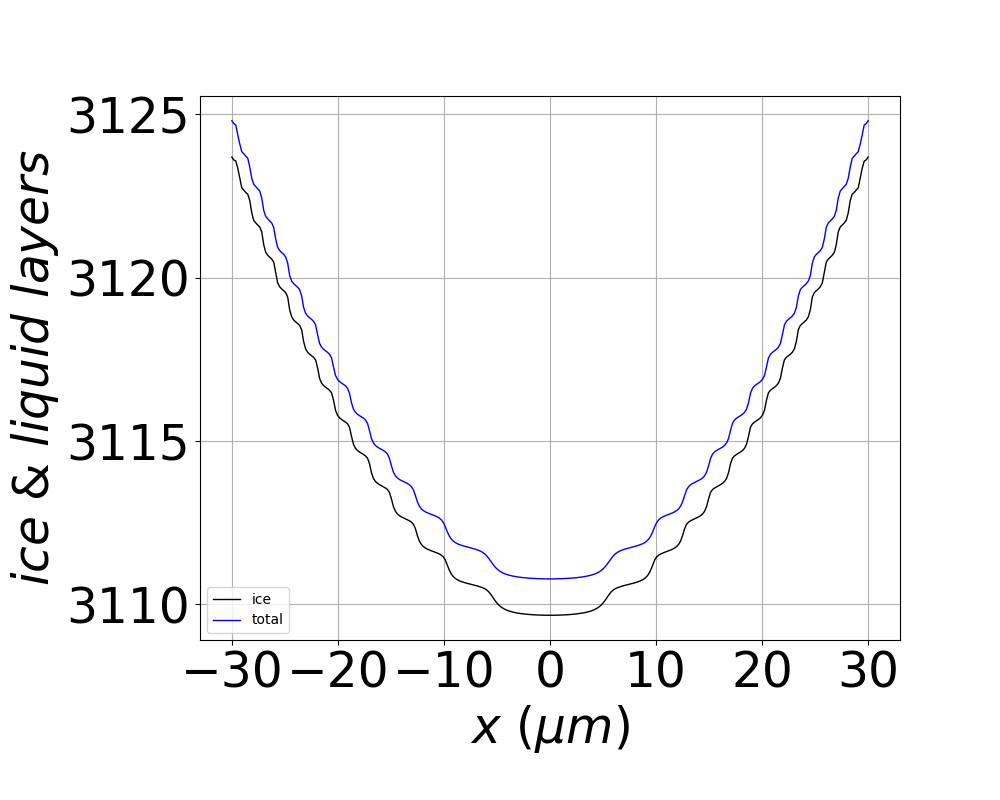

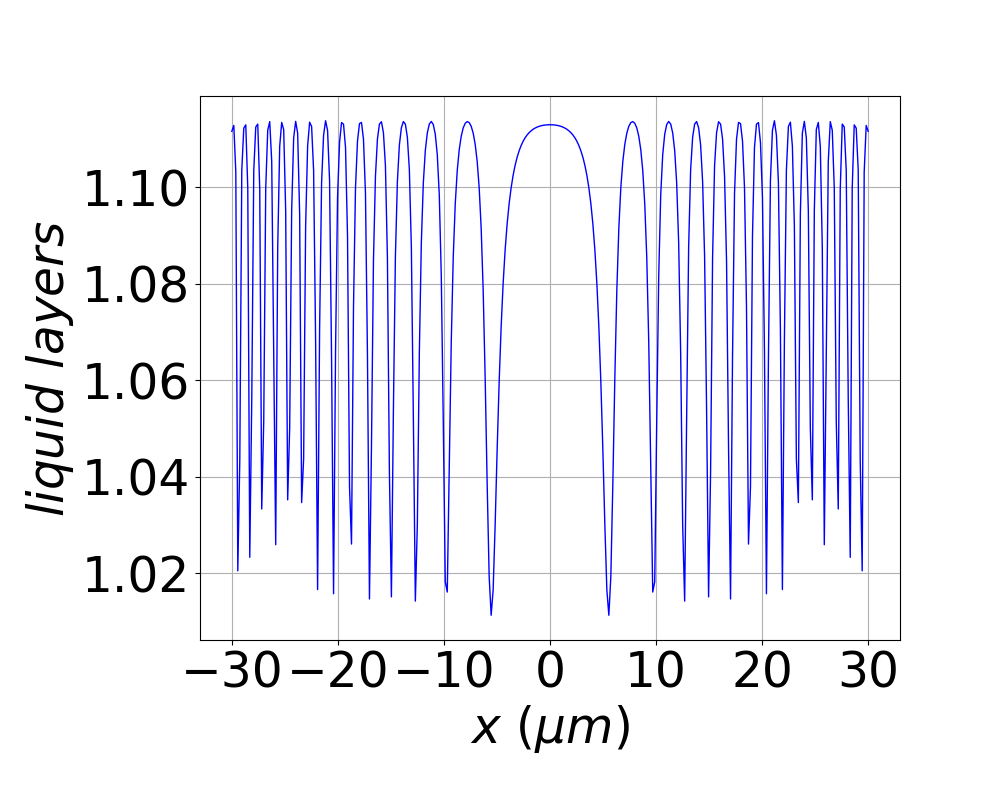

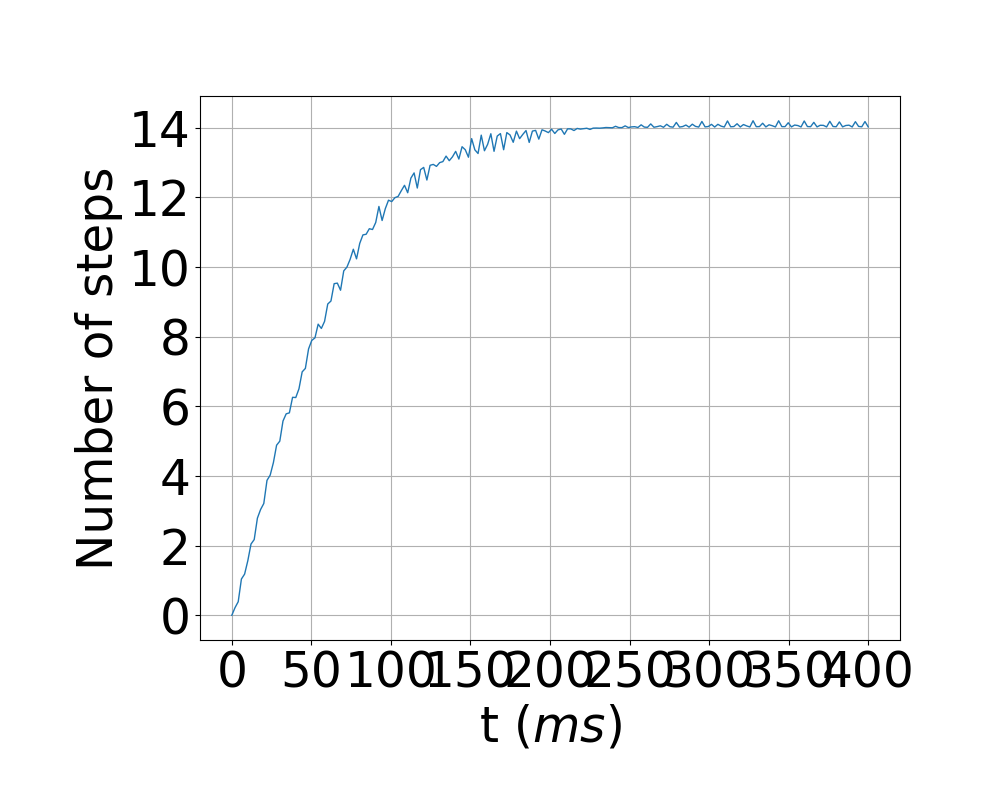

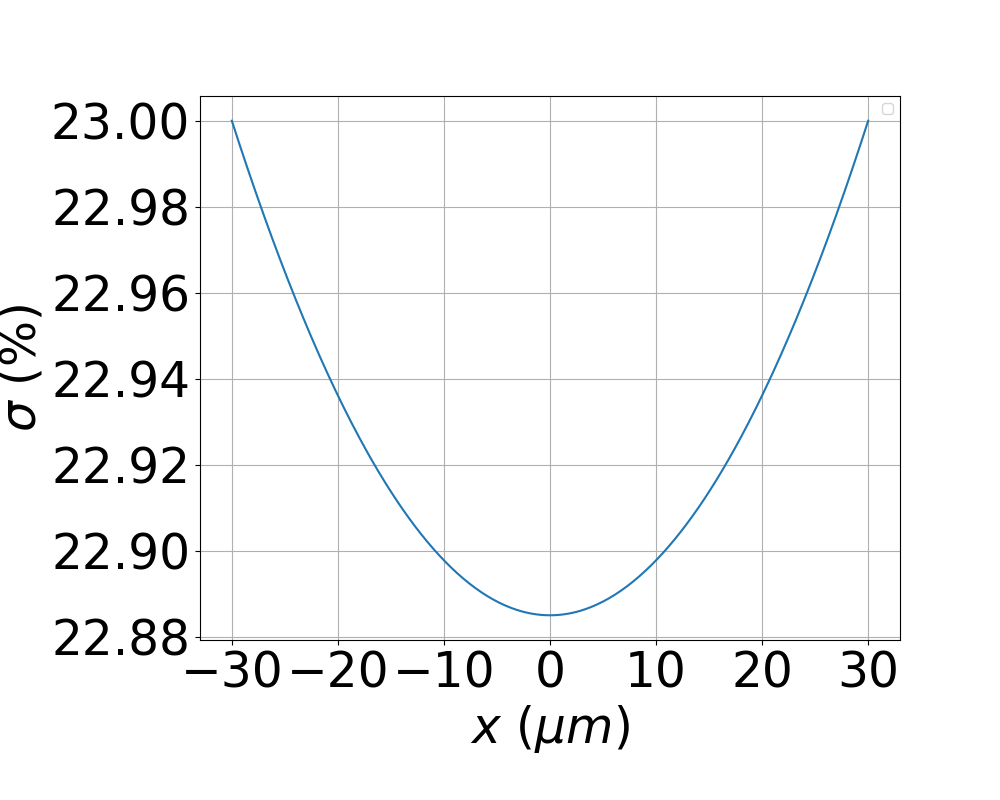

In [7]:
Ntotkeep_1D, NQLLkeep_1D = QLC.run_f1d(\
           NQLL_init_1D,Ntot_init_1D,tkeep_1Darr,\
           Nbar, Nstar, sigma0, nu_kin_mlyperus, Doverdeltax2, tau_eq, sigmaI_QLC,\
           AssignQuantity,\
           verbose=0, odemethod='RK45')
Nicekeep_1D = Ntotkeep_1D-NQLLkeep_1D

# Reporting and graphing
# Label for graphs
title_params = \
        "{:.0f}".format(L.magnitude)+' '+str(L.units)+\
        ", "+np.format_float_scientific(D.magnitude,precision=2)+" "+str(D.units)+\
        "\n"+\
        "{:.0f}".format(nu_kin.magnitude)+' '+str(nu_kin.units)+\
        "\n"+\
        "{:.3f}".format(sigmaI_corner.magnitude)+' '+str(sigmaI_corner.units)+\
        ", "+"{:.1f}".format(tau_eq.magnitude)+' '+str(tau_eq.units)+\
        ", "+"{:.3f}".format(c_r.magnitude * 100)+'%'+\
        ", "+odemethod+\
        "\n"
    
g_ice_QLC = QLC.report_1d_growth_results(\
        x_QLC,tkeep_1Darr,NQLLkeep_1D,Ntotkeep_1D,Nicekeep_1D,h_pr, \
        graphics=True,title_params=title_params)

plt.figure(figsize=(figsize))
plt.plot(x_QLC,sigmaI_QLC * 100)
plt.xlabel('$x \ (\mu m$)',fontsize=fontsize)
plt.ylabel('$\sigma$ (%)',fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.subplots_adjust(bottom=margin) 
plt.subplots_adjust(left=margin)
plt.grid(True)
plt.legend()

10 % elapsed time is 0.169 minutes
20 % elapsed time is 0.322 minutes
30 % elapsed time is 0.481 minutes
40 % elapsed time is 0.644 minutes
50 % elapsed time is 0.812 minutes
60 % elapsed time is 0.978 minutes
70 % elapsed time is 1.144 minutes
80 % elapsed time is 1.311 minutes
90 % elapsed time is 1.478 minutes
100% done
status =  0
message =  The solver successfully reached the end of the integration interval.
['message', 'nfev', 'njev', 'nlu', 'sol', 'status', 'success', 't', 't_events', 'y', 'y_events']


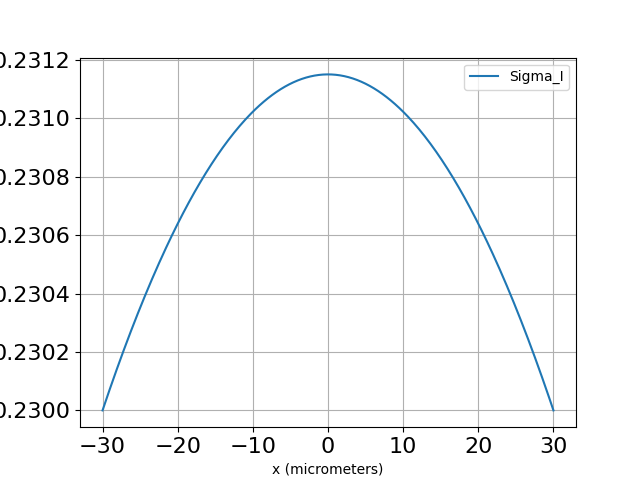

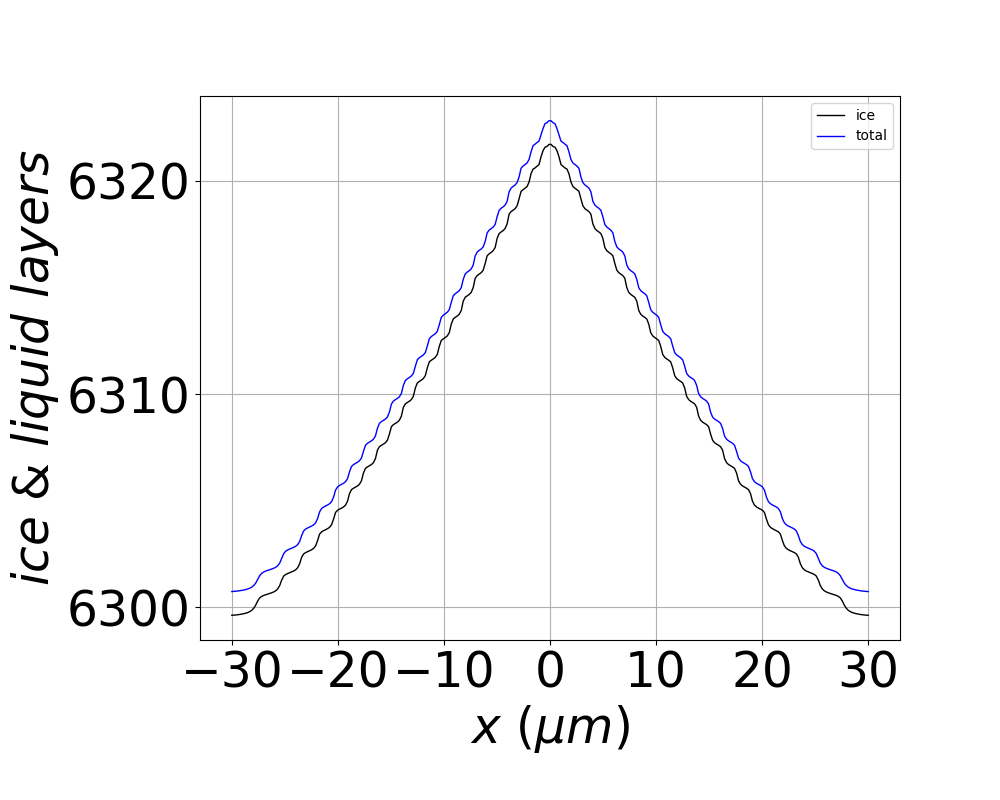

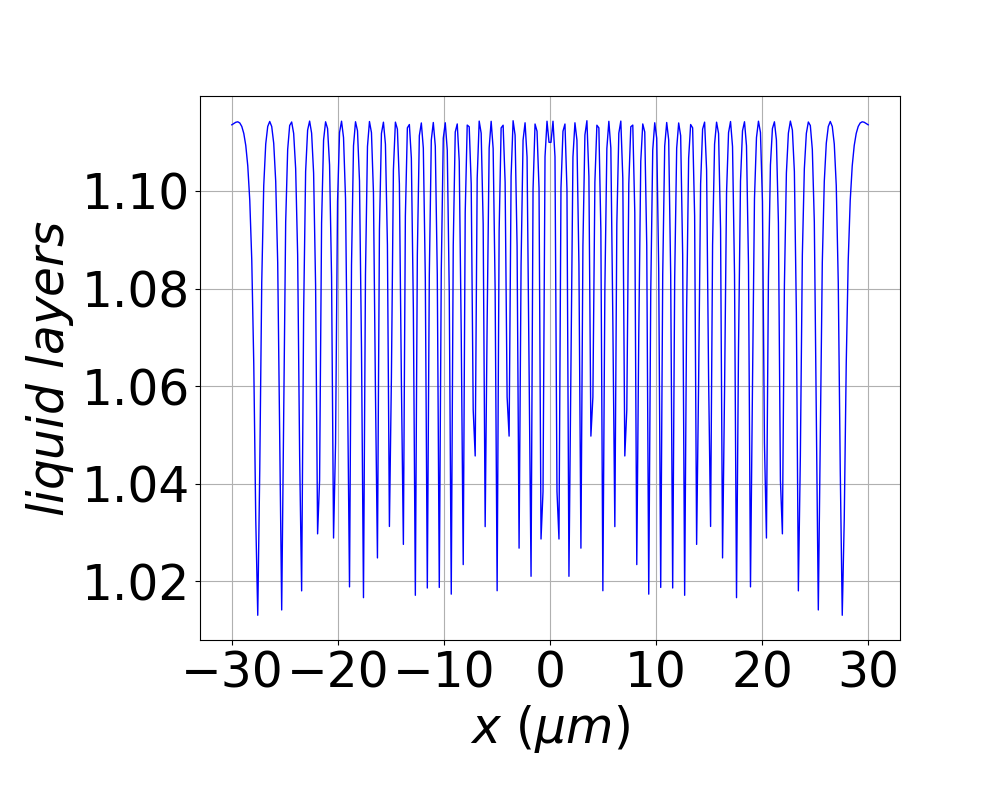

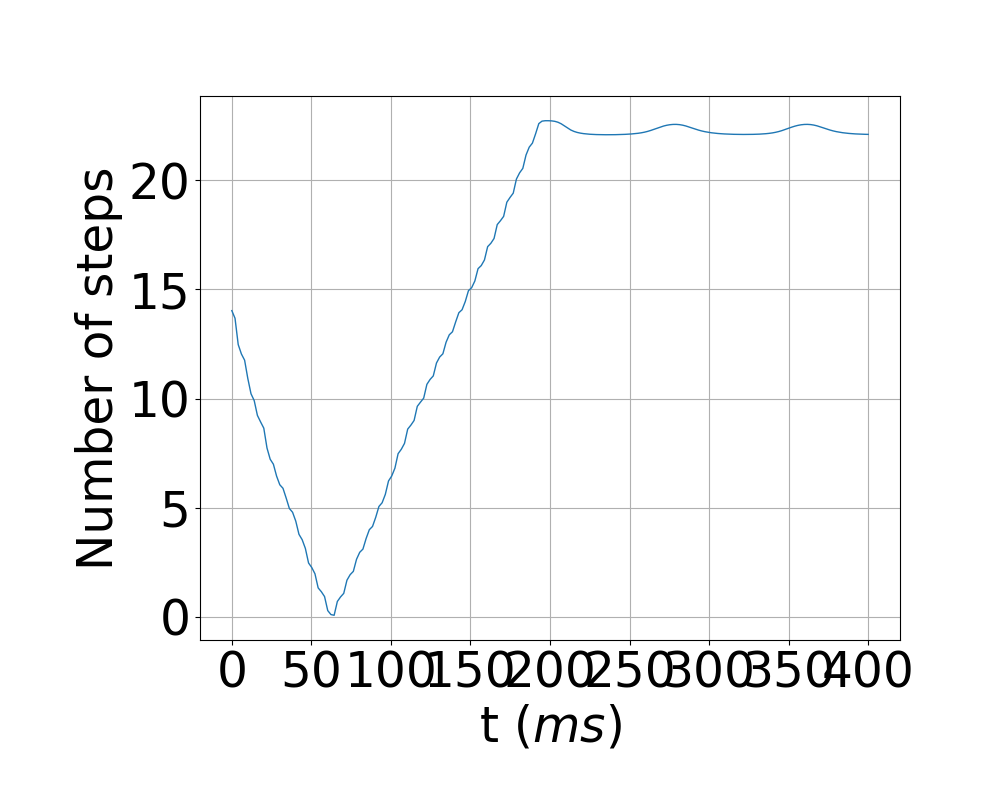

In [8]:
sigmaI_QLC = -1 * sigmaI_QLC + 2 * sigmaI_QLC[0] #keep1
tkeep_1Darr = np.linspace(0,runtime,ntimes)

plt.figure()
plt.plot(x_QLC,sigmaI_QLC,label="Sigma_I")
plt.xlabel('x (micrometers)')
plt.grid(True)
plt.legend()


Ntotkeep_1D_abl, NQLLkeep_1D_abl = QLC.run_f1d(\
           NQLLkeep_1D[-1],Ntotkeep_1D[-1],tkeep_1Darr,\
           Nbar, Nstar, sigma0, nu_kin_mlyperus, Doverdeltax2, tau_eq, sigmaI_QLC,\
           AssignQuantity,\
           verbose=0, odemethod='RK45')
Nicekeep_1D_abl = Ntotkeep_1D_abl-NQLLkeep_1D_abl

g_ice_QLC = QLC.report_1d_growth_results(\
        x_QLC,tkeep_1Darr,NQLLkeep_1D_abl,Ntotkeep_1D_abl,Nicekeep_1D_abl,h_pr, \
        graphics=True,title_params=title_params)

10 % elapsed time is 0.170 minutes
20 % elapsed time is 0.328 minutes
30 % elapsed time is 0.489 minutes
40 % elapsed time is 0.647 minutes
50 % elapsed time is 0.807 minutes
60 % elapsed time is 0.968 minutes
70 % elapsed time is 1.128 minutes
80 % elapsed time is 1.290 minutes
90 % elapsed time is 1.450 minutes
100% done
status =  0
message =  The solver successfully reached the end of the integration interval.
['message', 'nfev', 'njev', 'nlu', 'sol', 'status', 'success', 't', 't_events', 'y', 'y_events']


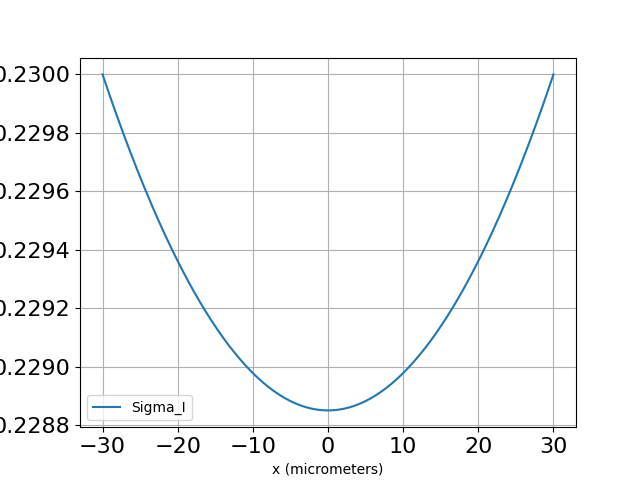

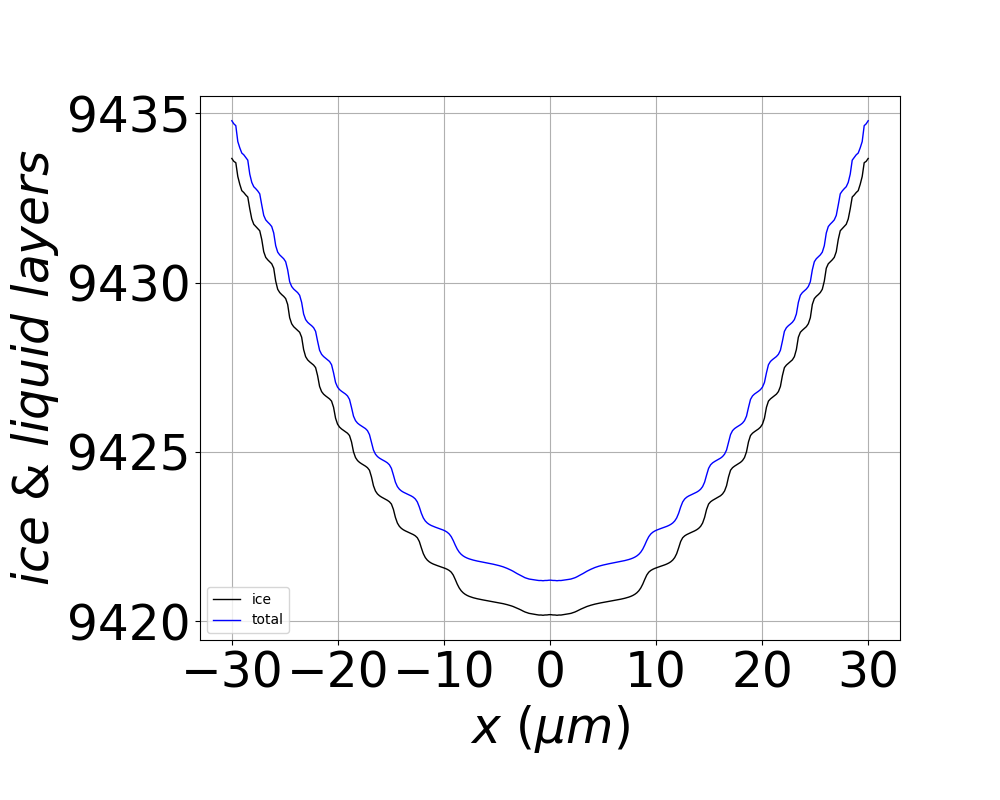

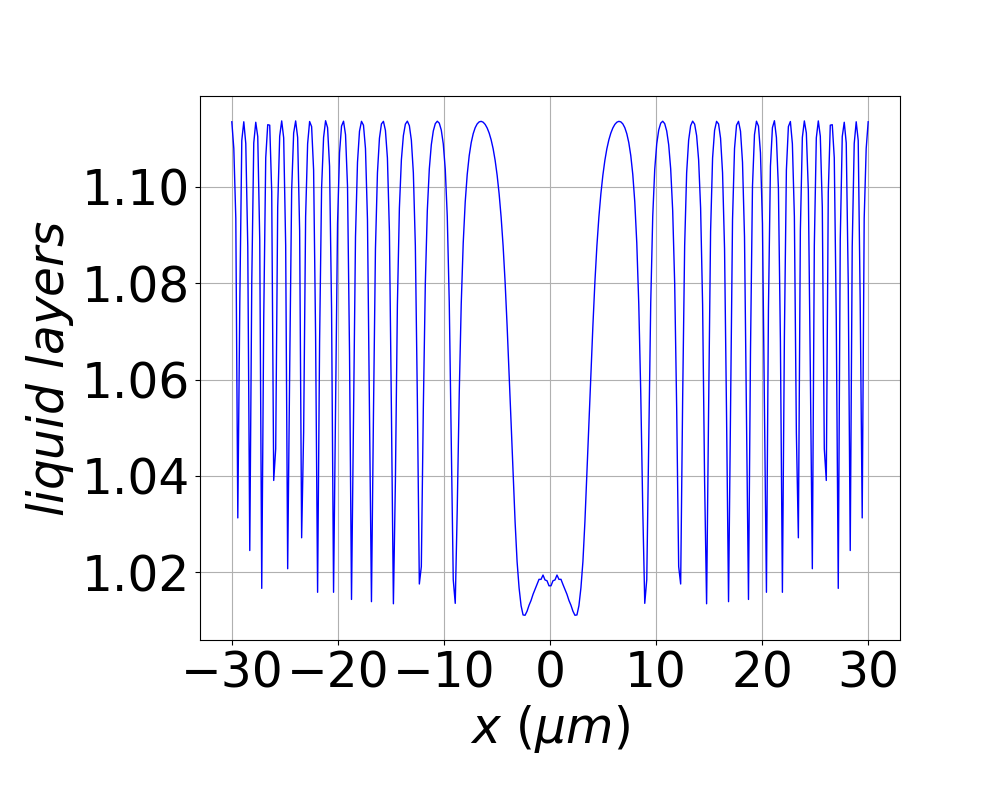

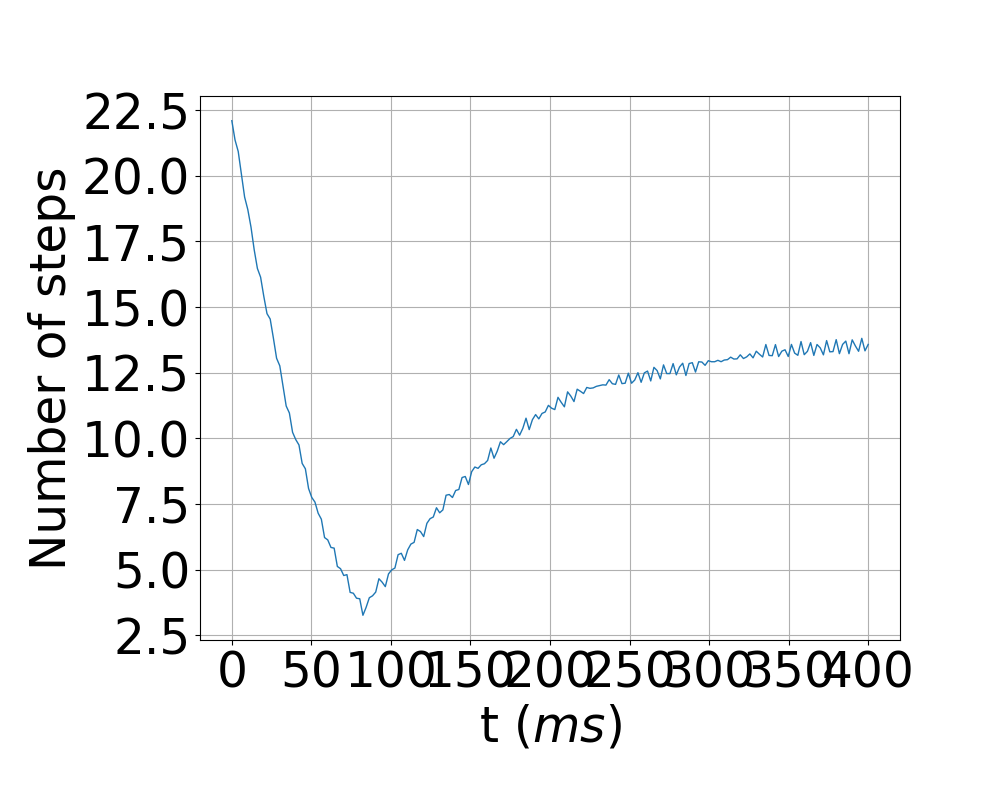

In [9]:
sigmaI_QLC = sigmaI_corner*(c_r*(x_QLC/L)**2+1-c_r)
tkeep_1Darr = np.linspace(0,runtime,ntimes)

plt.figure()
plt.plot(x_QLC,sigmaI_QLC,label="Sigma_I")
plt.xlabel('x (micrometers)')
plt.grid(True)
plt.legend()


Ntotkeep_1D_final, NQLLkeep_1D_final = QLC.run_f1d(\
           NQLLkeep_1D_abl[-1],Ntotkeep_1D_abl[-1],tkeep_1Darr,\
           Nbar, Nstar, sigma0, nu_kin_mlyperus, Doverdeltax2, tau_eq, sigmaI_QLC,\
           AssignQuantity,\
           verbose=0, odemethod='RK45')
Nicekeep_1D_final = Ntotkeep_1D_final-NQLLkeep_1D_final

g_ice_QLC = QLC.report_1d_growth_results(\
        x_QLC,tkeep_1Darr,NQLLkeep_1D_final,Ntotkeep_1D_final,Nicekeep_1D_final,h_pr, \
        graphics=True,title_params=title_params)

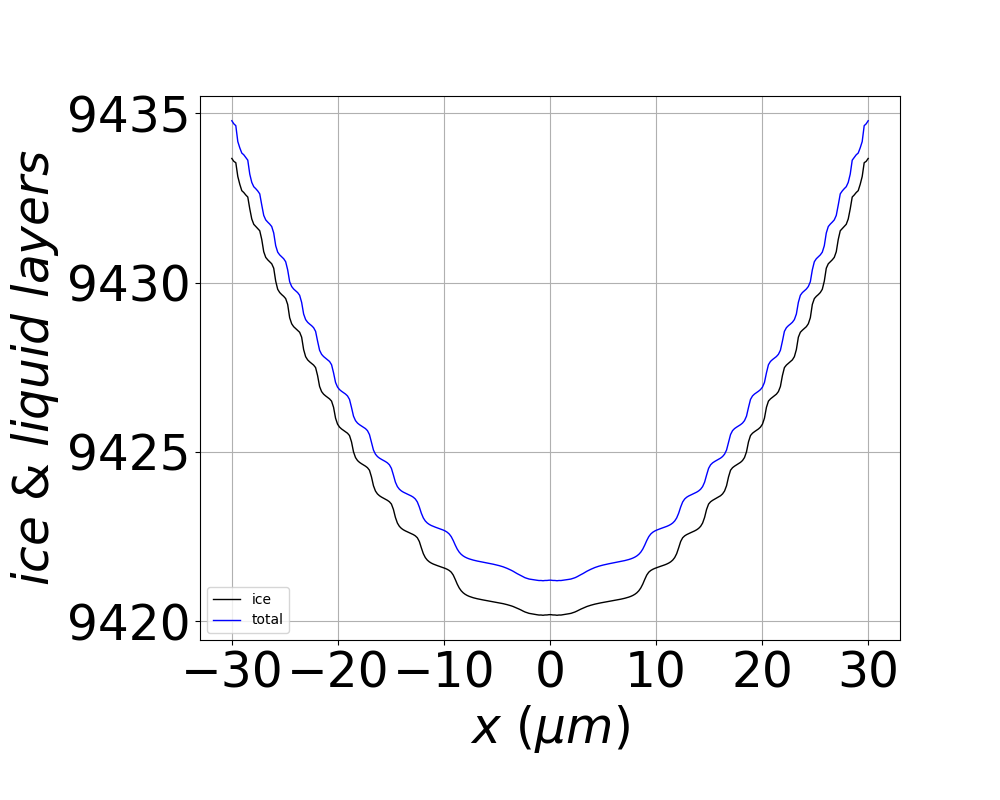

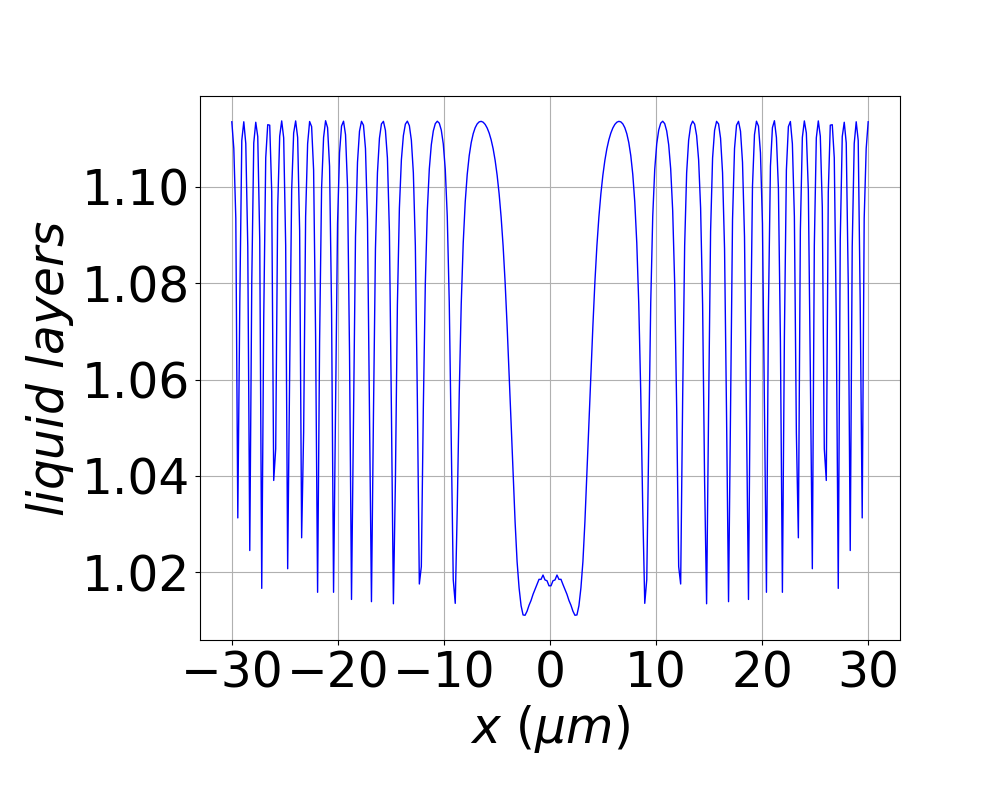

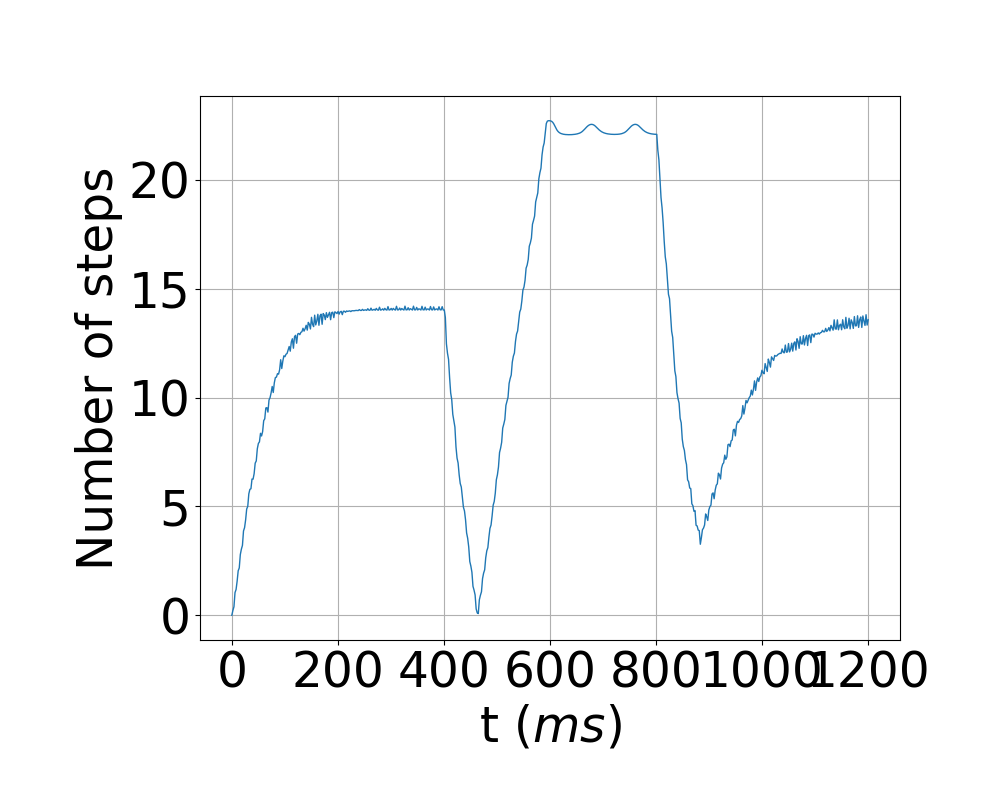

In [10]:
a = np.shape(NQLLkeep_1D_abl)
tot_time = ntimes * 3
a = (tot_time, nx_crystal)

tkeep_1Darr = np.linspace(0,runtime * 3,ntimes * 3)

NQLLkeep_1D_full = np.zeros(a)
for i in range(len(NQLLkeep_1D)):
    NQLLkeep_1D_full[i] = NQLLkeep_1D[i]
for i in range(len(NQLLkeep_1D_abl)):
    NQLLkeep_1D_full[i + len(NQLLkeep_1D)] = NQLLkeep_1D_abl[i]
for i in range(len(NQLLkeep_1D_abl)):
    NQLLkeep_1D_full[i + 2 * len(NQLLkeep_1D)] = NQLLkeep_1D_final[i]

Ntotkeep_1D_full = np.zeros(a)
for i in range(len(NQLLkeep_1D)):
    Ntotkeep_1D_full[i] = Ntotkeep_1D[i]
for i in range(len(NQLLkeep_1D_abl)):
    Ntotkeep_1D_full[i + len(Ntotkeep_1D)] = Ntotkeep_1D_abl[i]
for i in range(len(NQLLkeep_1D_abl)):
    Ntotkeep_1D_full[i + 2 * len(NQLLkeep_1D)] = Ntotkeep_1D_final[i]

Nicekeep_1D_full = Ntotkeep_1D_full-NQLLkeep_1D_full

g_ice_QLC = QLC.report_1d_growth_results(\
        x_QLC,tkeep_1Darr,NQLLkeep_1D_full,Ntotkeep_1D_full,Nicekeep_1D_full,h_pr, \
        graphics=True,title_params=title_params)

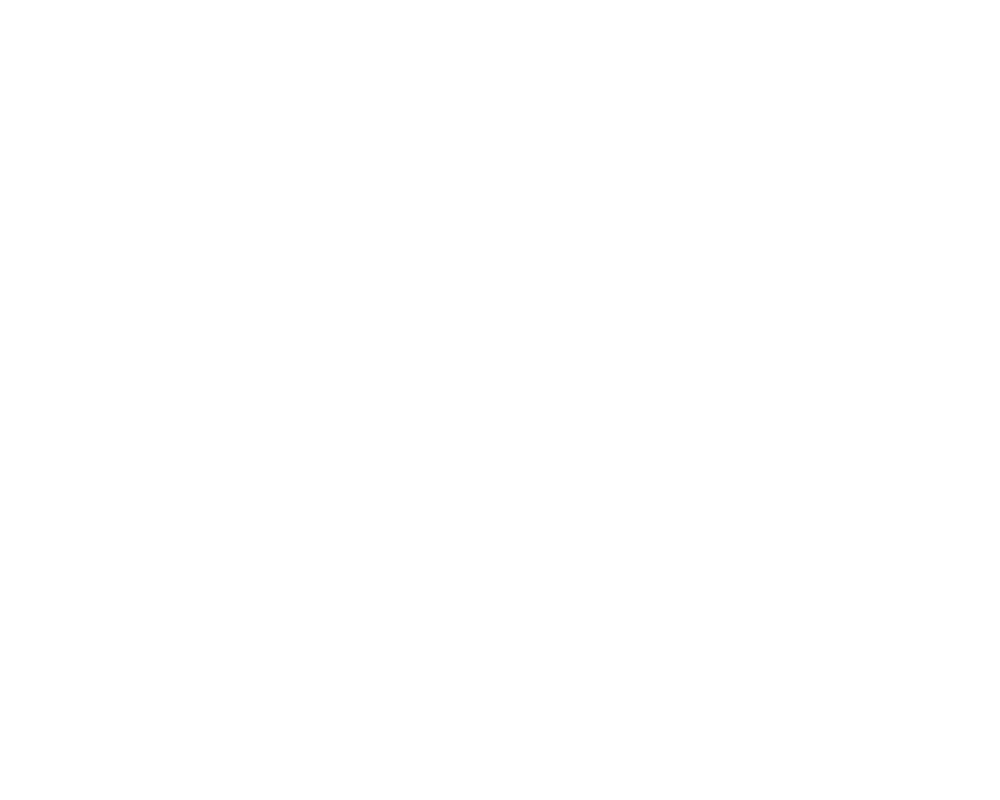

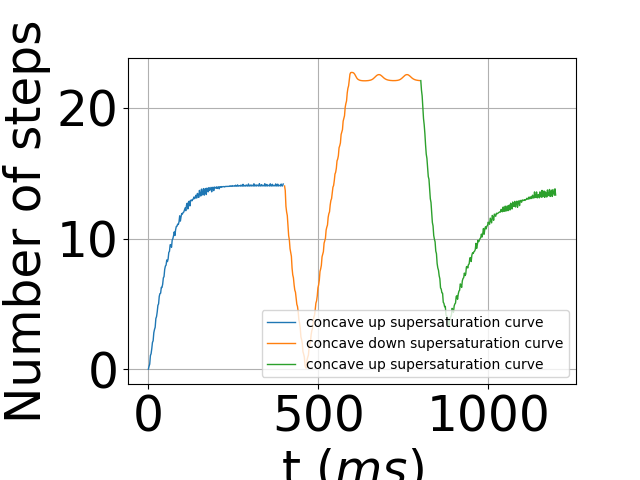

In [28]:
# Plot number of steps over time
plt.figure(figsize=(figsize))
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
f = np.max(Ntotkeep_1D_full,axis=1) - np.min(Ntotkeep_1D_full,axis=1)
a = f[0 : 199]
b = f[200 : 399]
c = f[400 : 599]

plt.figure()
plt.plot(tkeep_1Darr[0 : 199].magnitude/1e3,a,lw=linewidth, label = "concave up supersaturation curve")
plt.plot(tkeep_1Darr[200 : 399].magnitude/1e3,b,lw=linewidth, label = "concave down supersaturation curve")
plt.plot(tkeep_1Darr[400 : 599].magnitude/1e3,c,lw=linewidth, label = "concave up supersaturation curve")
plt.xlabel('t ($m s$)',fontsize=fontsize)
plt.ylabel('Number of steps',fontsize=fontsize)
#plt.title(title_entire,fontsize=titlefontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.subplots_adjust(bottom=margin) 
plt.subplots_adjust(left=margin)
plt.legend()
plt.grid('on')

600

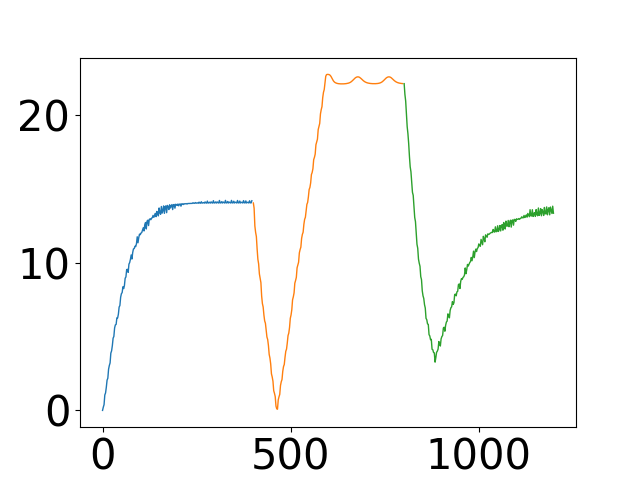

In [24]:
a = f[0 : 199]
b = f[200 : 399]
c = f[400 : 599]

plt.figure()
plt.plot(tkeep_1Darr[0 : 199].magnitude/1e3,a,lw=linewidth)
plt.plot(tkeep_1Darr[200 : 399].magnitude/1e3,b,lw=linewidth)
plt.plot(tkeep_1Darr[400 : 599].magnitude/1e3,c,lw=linewidth)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


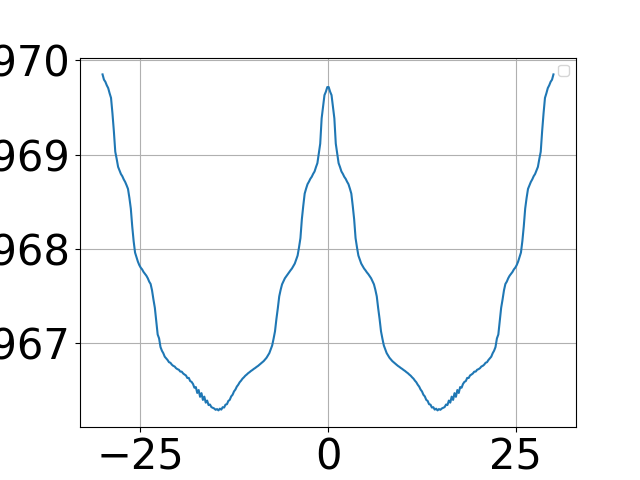

In [12]:
plt.figure()
plt.plot(x_QLC,Ntotkeep_1D_full[442])
plt.xlabel('x (micrometers)')
plt.grid(True)
plt.legend()